#**1. Libraries**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# **2. Regression Task using Housing Dataset**

## 2.1 Importing dataset from GitHub

In [33]:
df_housing = pd.read_csv('https://raw.githubusercontent.com/ryuh-h/ml-regression-classification/refs/heads/main/COMP1816_Housing_Dataset_Regression.csv')

In [34]:
df_housing.head()

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,1,-122.12,37.70,17,2488,617.0,1287,538,2.9922,179900,NEAR BAY
1,2,-122.21,38.10,36,3018,557.0,1445,556,3.8029,129900,NEAR BAY
2,3,-122.22,38.11,43,1939,353.0,968,392,3.1848,112700,NEAR BAY
3,4,-122.20,37.78,52,2300,443.0,1225,423,3.5398,158400,NEAR BAY
4,5,-122.19,37.79,50,954,217.0,546,201,2.6667,172800,NEAR BAY


In [35]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   No.                 1000 non-null   int64  
 1   longitude           1000 non-null   float64
 2   latitude            1000 non-null   float64
 3   housing_median_age  1000 non-null   int64  
 4   total_rooms         1000 non-null   int64  
 5   total_bedrooms      988 non-null    float64
 6   population          1000 non-null   int64  
 7   households          1000 non-null   int64  
 8   median_income       1000 non-null   float64
 9   median_house_value  1000 non-null   int64  
 10  ocean_proximity     993 non-null    object 
dtypes: float64(4), int64(6), object(1)
memory usage: 86.1+ KB


## 2.2 Data Preprocessing

In [36]:
# Calculate % of rows with null values to determine how to solve them
df_housing.isnull().values.ravel().sum() / len(df_housing) * 100

1.9

In [37]:
# Drop rows with null values
df_housing = df_housing.dropna(axis=0)

# Only 1.9% of rows had null values, dropping the rows would not affect regression

In [38]:
# Convert 'ocean_proximity' categorical column to numerical using one-hot encoding
df_housing = pd.get_dummies(df_housing, columns=["ocean_proximity"], drop_first=True)

In [39]:
df_housing.head()

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,1,-122.12,37.70,17,2488,617.0,1287,538,2.9922,179900,False,True,False
1,2,-122.21,38.10,36,3018,557.0,1445,556,3.8029,129900,False,True,False
2,3,-122.22,38.11,43,1939,353.0,968,392,3.1848,112700,False,True,False
3,4,-122.20,37.78,52,2300,443.0,1225,423,3.5398,158400,False,True,False
4,5,-122.19,37.79,50,954,217.0,546,201,2.6667,172800,False,True,False


In [40]:
# Define Features (X) and Target Variable (y)
X = df_housing.drop(columns=["median_house_value", "No."])  # Drop ID & target
y = df_housing["median_house_value"]

In [41]:
# Split dataset: Last 190 rows for test set (as per coursework instruction)
X_train_full, X_test, y_train_full, y_test = X.iloc[:-190], X.iloc[-190:], y.iloc[:-190], y.iloc[-190:]

# Further split training set into training & validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [42]:
# Standardize numerical features (Recommended for Gradient Boosting)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 2.3 Model 1: Linear Regression (Baseline Model)

In [43]:
# Train Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on validation set
pred_lin = lin_reg.predict(X_val)

In [44]:
# Evaluate performance
rmse_lin = np.sqrt(mean_squared_error(y_val, pred_lin))  # RMSE
r2_lin = r2_score(y_val, pred_lin)  # R² Score
mae_lin = mean_absolute_error(y_val, pred_lin)  # MAE

print(f"Linear Regression - RMSE: {rmse_lin:.2f}, R²: {r2_lin:.4f}, MAE: {mae_lin:.2f}")

Linear Regression - RMSE: 72679.80, R²: 0.5642, MAE: 55079.70


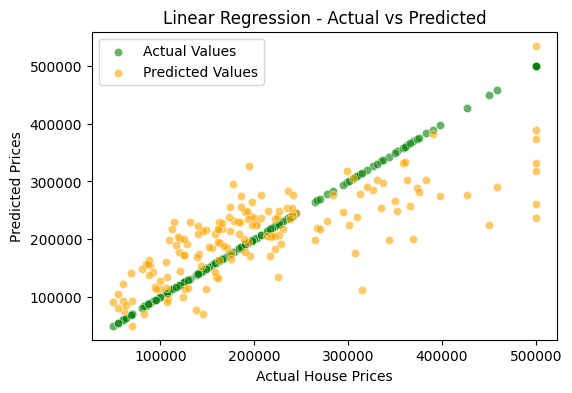

In [45]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_val, y=y_val, color="green", label="Actual Values", alpha=0.6)
sns.scatterplot(x=y_val, y=pred_lin, color="orange", label="Predicted Values", alpha=0.6)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted Prices")
plt.title("Linear Regression - Actual vs Predicted")
plt.show()

## 2.4 Model 2: Random Forest

Hyperparameter tuning for Random Forest Model

In [46]:
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring="neg_root_mean_squared_error")
rf_grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Random Forest:", rf_grid.best_params_)

Best parameters for Random Forest: {'max_depth': 15, 'n_estimators': 100}


In [47]:
# Train Random Forest Model
rf_reg = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict on validation set
pred_rf = rf_reg.predict(X_val)

In [48]:
# Evaluate performance
rmse_rf = np.sqrt(mean_squared_error(y_val, pred_rf))
r2_rf = r2_score(y_val, pred_rf)
mae_rf = mean_absolute_error(y_val, pred_rf)

print(f"Random Forest - RMSE: {rmse_rf:.2f}, R²: {r2_rf:.4f}, MAE: {mae_rf:.2f}")

Random Forest - RMSE: 70158.17, R²: 0.5939, MAE: 49713.82


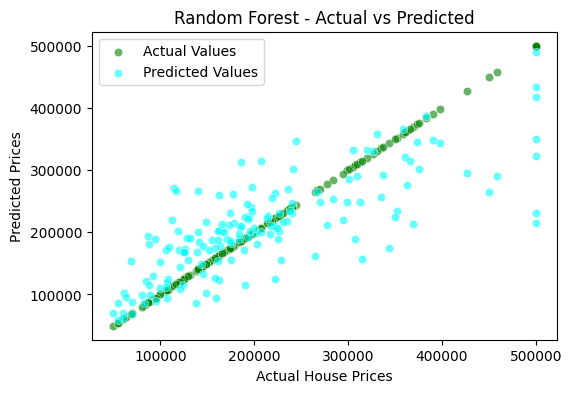

In [49]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_val, y=y_val, color="green", label="Actual Values", alpha=0.6)
sns.scatterplot(x=y_val, y=pred_rf, color="cyan", label="Predicted Values", alpha=0.6)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest - Actual vs Predicted")
plt.legend()
plt.show()

## 2.5 Model 3: Gradient Boosting

Hyperparameter tuning for Gradient Boosting Model

In [50]:
# Hyperparameter tuning for Gradient Boosting
gbr_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gbr_param_grid, cv=5, scoring="neg_root_mean_squared_error")
gbr_grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Gradient Boosting:", gbr_grid.best_params_)

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [51]:
# Train Gradient Boosting Model with Best Parameters
gbr = GradientBoostingRegressor(**gbr_grid.best_params_, random_state=42)
gbr.fit(X_train, y_train)

# Predict on validation set
pred_gbr = gbr.predict(X_val)

In [52]:
# Evaluate performance
rmse_gbr = np.sqrt(mean_squared_error(y_val, pred_gbr))
r2_gbr = r2_score(y_val, pred_gbr)
mae_gbr = mean_absolute_error(y_val, pred_gbr)

print(f"Gradient Boosting - RMSE: {rmse_gbr:.2f}, R²: {r2_gbr:.4f}, MAE: {mae_gbr:.2f}")

Gradient Boosting - RMSE: 62672.91, R²: 0.6759, MAE: 43925.05


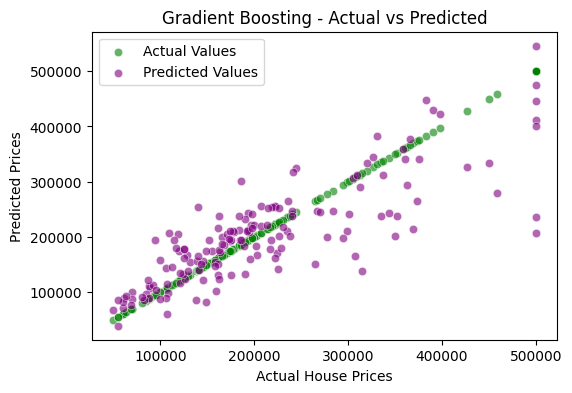

In [53]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_val, y=y_val, color="green", label="Actual Values", alpha=0.6)
sns.scatterplot(x=y_val, y=pred_gbr, color="purple", label="Predicted Values", alpha=0.6)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted Prices")
plt.title("Gradient Boosting - Actual vs Predicted")
plt.legend()
plt.show()

## 2.6 Comparing Model Performance

In [90]:
# Store results in a DataFrame for comparison
results_df_reg = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "RMSE": [rmse_lin, rmse_rf, rmse_gbr],
    "R²": [r2_lin, r2_rf, r2_gbr],
    "MAE": [mae_lin, mae_rf, mae_gbr]
})

# Print results nicely formatted
print("Regression Model Comparison:\n")
print(results_df_reg.to_string(index=False))  # Print without the default index

# Display as a styled Pandas table (Optional: Only works in Jupyter/Colab)
# results_df_reg.style.set_caption("Regression Model Performance Comparison")


Regression Model Comparison:

            Model         RMSE       R²          MAE
Linear Regression 72679.798145 0.564180 55079.698451
    Random Forest 70158.170935 0.593897 49713.816087
Gradient Boosting 62672.912600 0.675929 43925.052732


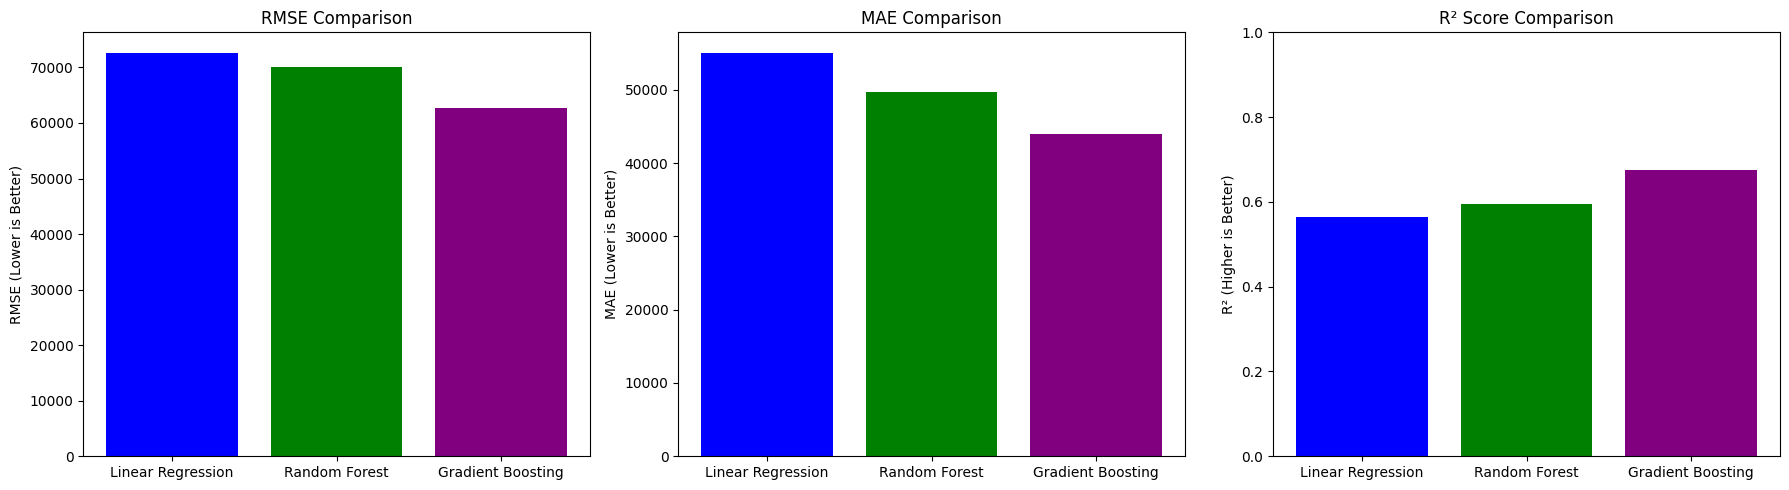

In [91]:
# Set figure size
fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # 3 plots: RMSE, MAE, R²

# RMSE Bar Chart
ax[0].bar(results_df_reg["Model"], results_df_reg["RMSE"], color=["blue", "green", "purple"])
ax[0].set_title("RMSE Comparison")
ax[0].set_ylabel("RMSE (Lower is Better)")

# MAE Bar Chart
ax[1].bar(results_df_reg["Model"], results_df_reg["MAE"], color=["blue", "green", "purple"])
ax[1].set_title("MAE Comparison")
ax[1].set_ylabel("MAE (Lower is Better)")

# R² Score Bar Chart
ax[2].bar(results_df_reg["Model"], results_df_reg["R²"], color=["blue", "green", "purple"])
ax[2].set_title("R² Score Comparison")
ax[2].set_ylabel("R² (Higher is Better)")
ax[2].set_ylim(0, 1)  # Ensure R² scale is from 0 to 1

plt.tight_layout()
plt.show()

# **3. Classification Task using Titanic Dataset**

## 3.1 Importing Dataset from GitHub

In [56]:
df_titanic = pd.read_csv("https://raw.githubusercontent.com/ryuh-h/ml-regression-classification/refs/heads/main/COMP1816_Titanic_Dataset_Classification.csv")

In [57]:
df_titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket No.,Fare,Embarked,Survival
0,1,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,S,0.0
1,2,1.0,NaN,female,38.0,1.0,0.0,PC 17599,71.2833,C,1.0
2,3,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,S,1.0
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,S,1.0
4,5,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,S,0.0


In [58]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  890 non-null    int64  
 1   Pclass       880 non-null    float64
 2   Name         885 non-null    object 
 3   Sex          890 non-null    object 
 4   Age          715 non-null    float64
 5   SibSp        888 non-null    float64
 6   Parch        888 non-null    float64
 7   Ticket No.   888 non-null    object 
 8   Fare         888 non-null    float64
 9   Embarked     884 non-null    object 
 10  Survival     886 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 76.6+ KB


## 3.2 Data Preprocessing

In [59]:
# Calculate % of rows with null values to determine how to solve them
df_titanic.isnull().values.ravel().sum() / len(df_titanic) * 100

23.370786516853933

In [60]:
# Fill missing values for 'Age' with median
df_titanic['Age'] = df_titanic['Age'].fillna(df_titanic['Age'].median())

# Fill missing values for 'Embarked' with most common port
df_titanic['Embarked'] = df_titanic['Embarked'].fillna(df_titanic['Embarked'].mode()[0])

In [61]:
# Convert categorical variables into numerical using Label Encoding
df_titanic['Sex'] = LabelEncoder().fit_transform(df_titanic['Sex'])  # 0 = Female, 1 = Male
df_titanic = pd.get_dummies(df_titanic, columns=['Embarked'], drop_first=True)  # One-hot encode Embarked

In [62]:
# Drop remaining rows with null values
df_titanic = df_titanic.dropna(axis=0)

In [63]:
# Drop unnecessary columns (Passenger Name, Ticket, Cabin)
df_titanic = df_titanic.drop(columns=['Name', 'Ticket No.'])

In [64]:
df_titanic.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survival,Embarked_Q,Embarked_S
0,1,3.0,1,22.0,1.0,0.0,7.2500,0.0,False,True
2,3,3.0,0,26.0,0.0,0.0,7.9250,1.0,False,True
3,4,1.0,0,35.0,1.0,0.0,53.1000,1.0,False,True
4,5,3.0,1,35.0,0.0,0.0,8.0500,0.0,False,True
6,7,1.0,1,54.0,0.0,0.0,51.8625,0.0,False,True


In [65]:
# Define Features (X) and Target Variable (y)
X = df_titanic.drop(columns=['Survival'])  # Drop target
y = df_titanic['Survival']  # Target variable

In [66]:
# Split dataset: Last 140 rows for test set (as per coursework instruction)
X_train_full, X_test, y_train_full, y_test = X.iloc[:-140], X.iloc[-140:], y.iloc[:-140], y.iloc[-140:]

# Further split training set into training & validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [67]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 3.3 Model 1: Logistic Regression (Baseline Model)

In [68]:
# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict on validation set
pred_log_reg = log_reg.predict(X_val)

In [69]:
# Evaluate performance
acc_log_reg = accuracy_score(y_val, pred_log_reg)
prec_log_reg = precision_score(y_val, pred_log_reg)
rec_log_reg = recall_score(y_val, pred_log_reg)
f1_log_reg = f1_score(y_val, pred_log_reg)

print(f"Logistic Regression - Accuracy: {acc_log_reg:.2f}, Precision: {prec_log_reg:.2f}, Recall: {rec_log_reg:.2f}, F1-Score: {f1_log_reg:.2f}")

Logistic Regression - Accuracy: 0.81, Precision: 0.83, Recall: 0.67, F1-Score: 0.74


In [70]:
# Classification Report for Logistic Regression
print("\nClassification Report - Logistic Regression:\n")
print(classification_report(y_val, pred_log_reg, target_names=["Not Survived", "Survived"]))


Classification Report - Logistic Regression:

              precision    recall  f1-score   support

Not Survived       0.80      0.91      0.85        87
    Survived       0.83      0.67      0.74        60

    accuracy                           0.81       147
   macro avg       0.82      0.79      0.80       147
weighted avg       0.81      0.81      0.81       147



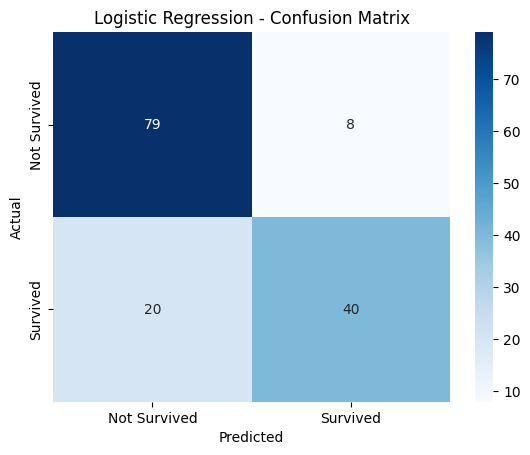

In [71]:
# Confusion Matrix for Logistic Regression
conf_matrix_log_reg = confusion_matrix(y_val, pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Survived", "Survived"],
            yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

## 3.4 Model 2: Random Forest

Hyperparameter Tuning for Random Forest

In [72]:
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring="accuracy")
rf_grid.fit(X_train, y_train)

print("Best parameters for Random Forest:", rf_grid.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}


In [73]:
# Train Random Forest Model with Best Parameters
rf_clf = RandomForestClassifier(**rf_grid.best_params_, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on validation set
pred_rf = rf_clf.predict(X_val)

In [74]:
# Evaluate performance
acc_rf = accuracy_score(y_val, pred_rf)
prec_rf = precision_score(y_val, pred_rf)
rec_rf = recall_score(y_val, pred_rf)
f1_rf = f1_score(y_val, pred_rf)

print(f"Random Forest - Accuracy: {acc_rf:.2f}, Precision: {prec_rf:.2f}, Recall: {rec_rf:.2f}, F1-Score: {f1_rf:.2f}")

Random Forest - Accuracy: 0.80, Precision: 0.79, Recall: 0.70, F1-Score: 0.74


In [75]:
# Classification Report for Random Forest
print("\nClassification Report - Random Forest:\n")
print(classification_report(y_val, pred_rf, target_names=["Not Survived", "Survived"]))


Classification Report - Random Forest:

              precision    recall  f1-score   support

Not Survived       0.81      0.87      0.84        87
    Survived       0.79      0.70      0.74        60

    accuracy                           0.80       147
   macro avg       0.80      0.79      0.79       147
weighted avg       0.80      0.80      0.80       147



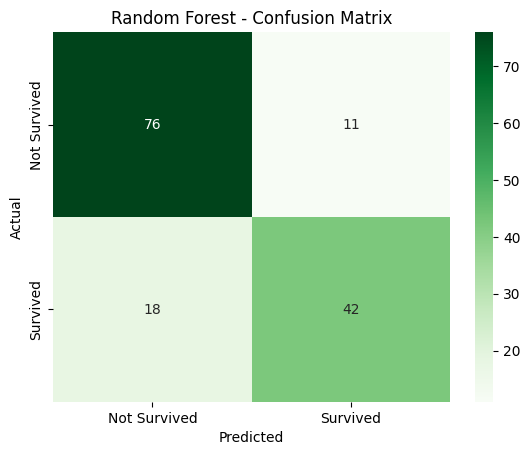

In [76]:
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_val, pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Not Survived", "Survived"],
            yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()

## 3.5 Model 3: Gradient Boosting Classifier

Hyperparameter Tuning for Gradient Boosting Classifier

In [77]:
gbc_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

gbc_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gbc_param_grid, cv=5, scoring="accuracy")
gbc_grid.fit(X_train, y_train)

print("Best parameters for Gradient Boosting Classifier:", gbc_grid.best_params_)

Best parameters for Gradient Boosting Classifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [78]:
# Train Gradient Boosting Model with Best Parameters
gbc_clf = GradientBoostingClassifier(**gbc_grid.best_params_, random_state=42)
gbc_clf.fit(X_train, y_train)

# Predict on validation set
pred_gbc = gbc_clf.predict(X_val)

In [79]:
# Evaluate performance
acc_gbc = accuracy_score(y_val, pred_gbc)
prec_gbc = precision_score(y_val, pred_gbc)
rec_gbc = recall_score(y_val, pred_gbc)
f1_gbc = f1_score(y_val, pred_gbc)

# Print metrics
print(f"Gradient Boosting Classifier - Accuracy: {acc_gbc:.2f}, Precision: {prec_gbc:.2f}, Recall: {rec_gbc:.2f}, F1-Score: {f1_gbc:.2f}")

Gradient Boosting Classifier - Accuracy: 0.82, Precision: 0.84, Recall: 0.68, F1-Score: 0.75


In [80]:
# Classification Report
print("\nClassification Report - Gradient Boosting Classifier:\n")
print(classification_report(y_val, pred_gbc, target_names=["Not Survived", "Survived"]))


Classification Report - Gradient Boosting Classifier:

              precision    recall  f1-score   support

Not Survived       0.81      0.91      0.85        87
    Survived       0.84      0.68      0.75        60

    accuracy                           0.82       147
   macro avg       0.82      0.80      0.80       147
weighted avg       0.82      0.82      0.81       147



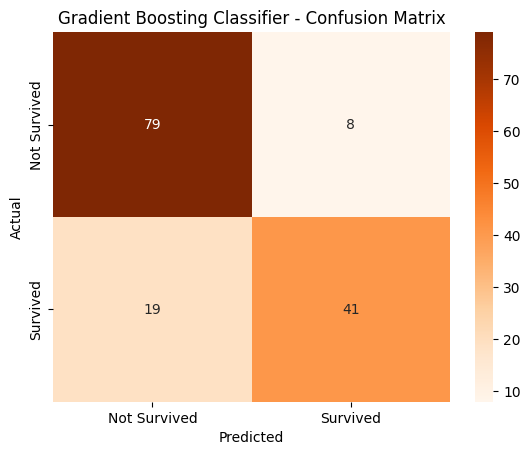

In [81]:
# Confusion Matrix Visualization
conf_matrix_gbc = confusion_matrix(y_val, pred_gbc)
sns.heatmap(conf_matrix_gbc, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Not Survived", "Survived"],
            yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting Classifier - Confusion Matrix")
plt.show()

## 3.6 Comparing Model Performance

In [82]:
# Create a DataFrame to store performance metrics for all models
results_df_class = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [acc_log_reg, acc_rf, acc_gbc],
    "Precision": [prec_log_reg, prec_rf, prec_gbc],
    "Recall": [rec_log_reg, rec_rf, rec_gbc],
    "F1-Score": [f1_log_reg, f1_rf, f1_gbc]
})

# Print the results DataFrame for tabular comparison
print("Model Performance Comparison:\n")
print(results_df_class)

Model Performance Comparison:

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.809524   0.833333  0.666667  0.740741
1        Random Forest  0.802721   0.792453  0.700000  0.743363
2    Gradient Boosting  0.816327   0.836735  0.683333  0.752294


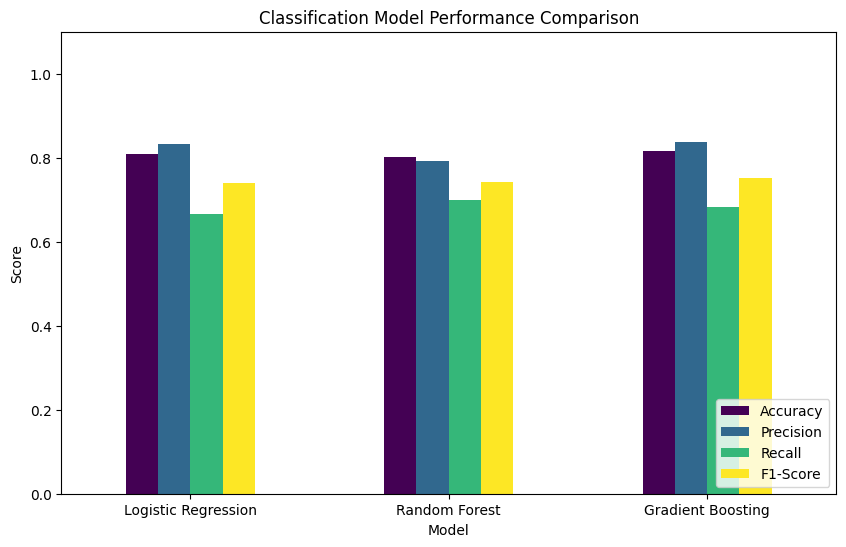

In [93]:
# Plot a bar chart for visual comparison
results_df_class.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Classification Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()